We solve the steady advection-diffusion equation $$-\kappa \Delta u + \mathbf{a}\cdot \nabla u = 0, \quad\text{where }\kappa =10^{-7} \text{ and } \mathbf{a} = \left(-y + 0.5\,,\,\, x - 0.5\right)^T $$

The domain is $0\le x, y\le 1$ and our solution satisfies the dirichlet boundary conditions indicated below. Especially important (in terms of stability) is the sine wave that extends from the center of the square to an edge.
<img src="files/ProblemSetup.png">
(pictures taken from this [paper](https://link.springer.com/content/pdf/10.1007/s11831-010-9042-5.pdf))

The exact solution (in the hyperbolic limit) is a solid of revolution of the sine wave about the z-axis through the center of the square.

In this notebook, we will isolate the midline boundary in a slightly different way. (Credit to Mike Johnson)

#### Methods Used
1. Galerkin (strong BCs)
2. SUPG (strong BCs)
3. Galerkin/Least squares (strong BCs)

## Galerkin

**Weak Form**: $$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k} \,a_k \, dx$$
where $N_i$ is a basis function.

optimize > solve > solving 90 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-18
optimize > constrained 90/441 dofs
optimize > optimum value 5.75e-08
solve > solving 351 dof system to machine precision using direct solver
solve > solver returned with residual 9e-18


<IPython.core.display.Javascript object>


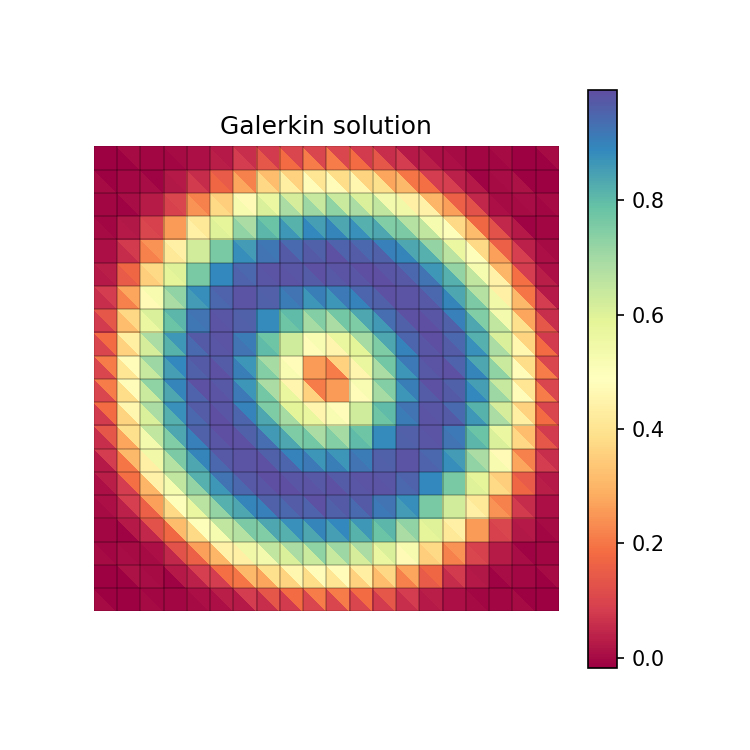

<IPython.core.display.Javascript object>


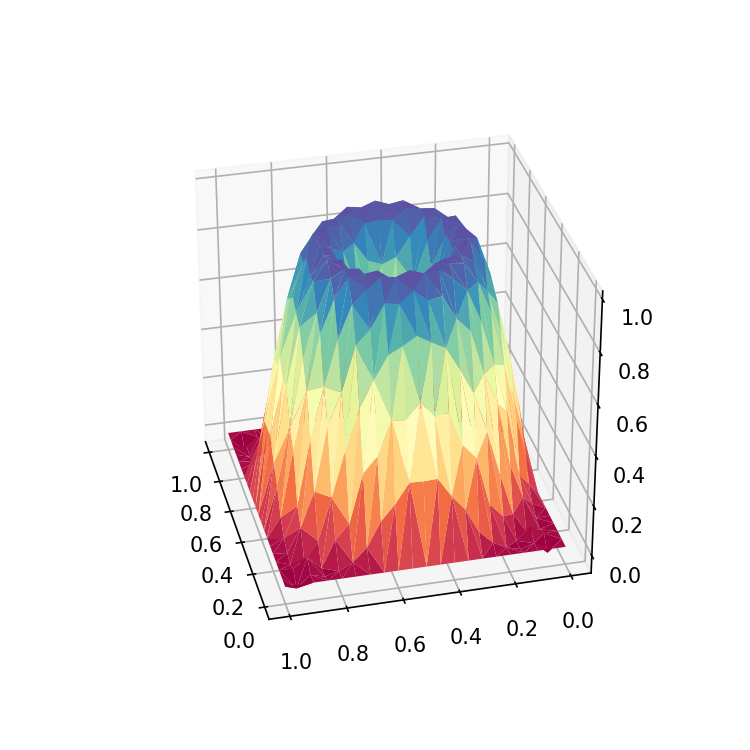

In [12]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

degree = 1 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes

topo, geom =ntl.mesh.unitsquare(nelems, etype) #ntl.mesh.gmsh('domain.msh') #
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#Dirichlet conditions

#tophalf of domain is defined via y - 0.5 > 0. Midline is one of the boundaries of this new domain 
halftopo = topo.trim(geom[1] - 0.50, maxrefine = 0, name= 'halfbnd') 
halfbtopo = halftopo.boundary #boundary of tophalf ie midline + top + top-right + top-left

# eval the vertices of the boundary elements of halftopo:
verts = halfbtopo.sample(*ntl.element.parse_legacy_ischeme("vertex")).eval(geom)

# now select the verts of the midline 
sub_halfbtopo = ntl.topology.SubsetTopology(halfbtopo, [halfbtopo.references[i]
                                                    if (verts[2*i][0] >= 0.5 and verts[2*i][1]==0.5 and verts[2*i+1][0] >= 0.5
                                                        and verts[2*i+1][1] == 0.5) else halfbtopo.references[i].empty 
                                                    for i in range(len(halfbtopo.references))])


sqr = sub_halfbtopo.integral('( u - sin(2 pi (x_0 - 0.5))  )^2 d:x' @ ns, degree = degree * 2)#

sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

#this converts our solution into arrays
bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap = plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

## SUPG

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, a_n N_{A, n} 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

optimize > solve > solving 90 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-18
optimize > constrained 90/441 dofs
optimize > optimum value 5.75e-08
solve > solving 351 dof system to machine precision using direct solver
solve > solver returned with residual 2e-17


<IPython.core.display.Javascript object>


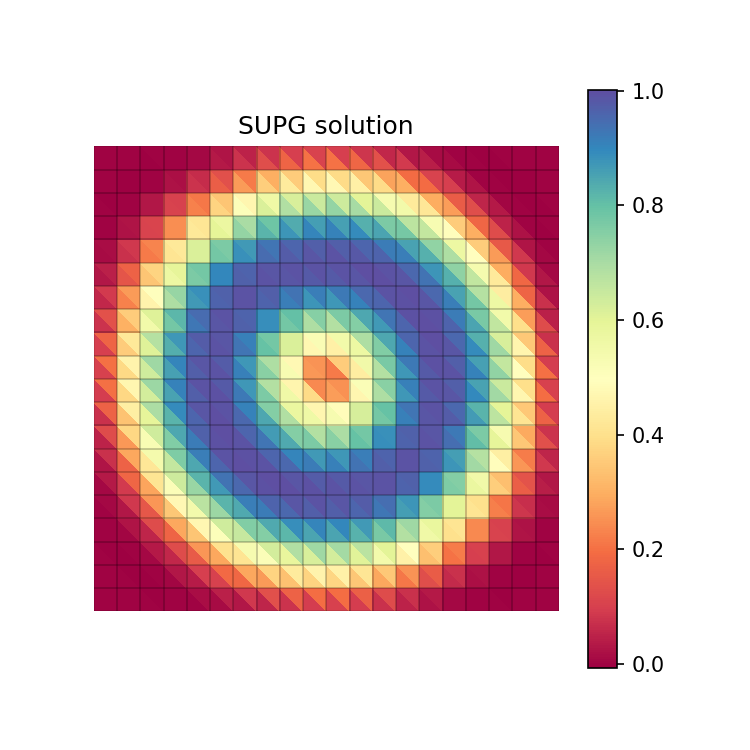

<IPython.core.display.Javascript object>


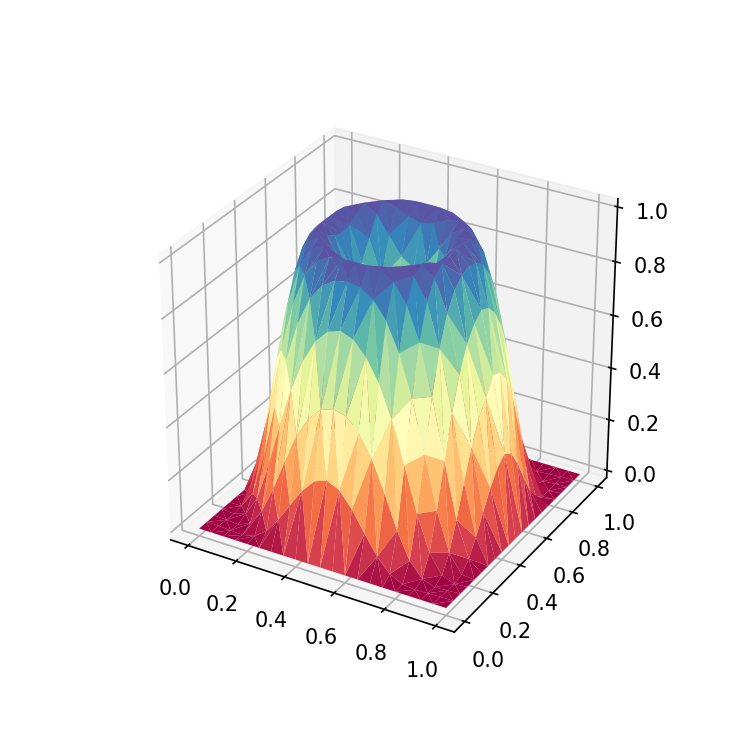

In [11]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 1 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes


topo, geom =  ntl.mesh.unitsquare(nelems, etype) 
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions

#Dirichlet conditions

#tophalf of domain is defined via y - 0.5 > 0. Midline is one of the boundaries of this new domain 
halftopo = topo.trim(geom[1] - 0.50, maxrefine = 0, name= 'halfbnd') 
halfbtopo = halftopo.boundary #boundary of tophalf ie midline + top + top-right + top-left

# eval the vertices of the boundary elements of halftopo:
verts = halfbtopo.sample(*ntl.element.parse_legacy_ischeme("vertex")).eval(geom)

# now select the verts of the midline 
sub_halfbtopo = ntl.topology.SubsetTopology(halfbtopo, [halfbtopo.references[i]
                                                    if (verts[2*i][0] >= 0.5 and verts[2*i][1]==0.5 and verts[2*i+1][0] >= 0.5
                                                        and verts[2*i+1][1] == 0.5) else halfbtopo.references[i].empty 
                                                    for i in range(len(halfbtopo.references))])


sqr = sub_halfbtopo.integral('( u - sin(2 pi (x_0 - 0.5))  )^2 d:x' @ ns, degree = degree * 2)#

sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )

cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)


## Galerkin/Least Squares

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, (-\kappa\,N_{A, rr}\,+\, a_n N_{A, n}) 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below. (In the code below I use quadratic basis elements. Otherwise the method reduces to SUPG)

optimize > solve > solving 180 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 180/1681 dofs
optimize > optimum value 4.36e-09
solve > solving 1501 dof system to machine precision using direct solver
solve > solver returned with residual 9e-17


<IPython.core.display.Javascript object>


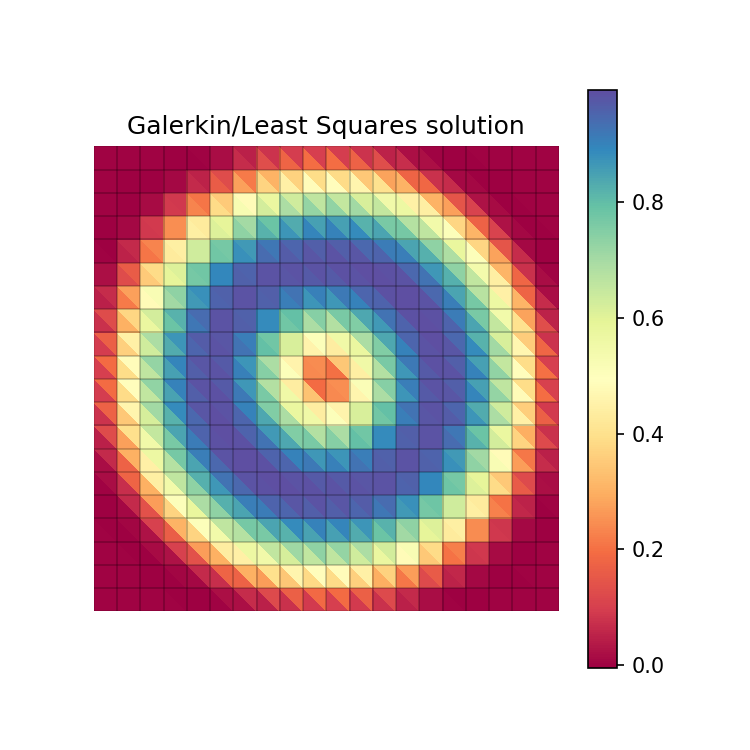

<IPython.core.display.Javascript object>


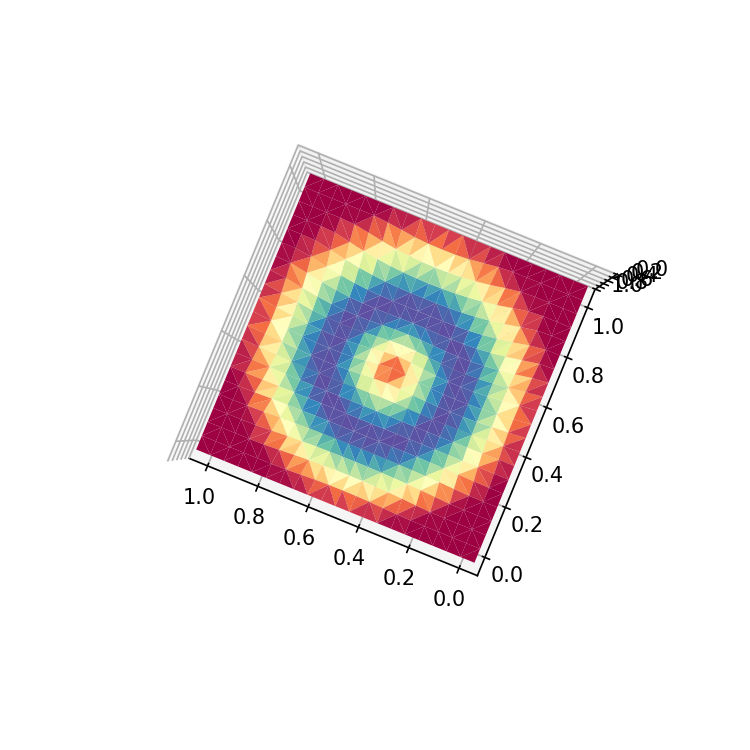

In [20]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 2 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes


topo, geom =  ntl.mesh.unitsquare(nelems, etype) 
ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions
#tophalf of domain is defined via y - 0.5 > 0. Midline is one of the boundaries of this new domain 
halftopo = topo.trim(geom[1] - 0.50, maxrefine = 0, name= 'halfbnd') 
halfbtopo = halftopo.boundary #boundary of tophalf ie midline + top + top-right + top-left

# eval the vertices of the boundary elements of halftopo:
verts = halfbtopo.sample(*ntl.element.parse_legacy_ischeme("vertex")).eval(geom)

# now select the verts of the midline 
sub_halfbtopo = ntl.topology.SubsetTopology(halfbtopo, [halfbtopo.references[i]
                                                    if (verts[2*i][0] >= 0.5 and verts[2*i][1]==0.5 and verts[2*i+1][0] >= 0.5
                                                        and verts[2*i+1][1] == 0.5) else halfbtopo.references[i].empty 
                                                    for i in range(len(halfbtopo.references))])


sqr = sub_halfbtopo.integral('( u - sin(2 pi (x_0 - 0.5))  )^2 d:x' @ ns, degree = degree * 2)#
sqr += topo.boundary['top'].integral('(u - 0)^2 d:x' @ns, degree = degree*2)
sqr += topo.boundary['bottom'].integral('(u - 0)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )

cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral('tau (-kappa basis_i,mm + a_k basis_i,k) (-kappa u_,jj + a_n u_,n)  d:x' @ ns,
                     degree= degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_GLS.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin/Least Squares solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

In [15]:
#help(ntl.element.parse_legacy_ischeme)
help(ntl.element)

Help on module nutils.element in nutils:

NAME
    nutils.element

DESCRIPTION
    The element module defines reference elements such as the
    :class:`LineReference` and :class:`TriangleReference`, but also more exotic
    objects like the :class:`MosaicReference`. A set of (interconnected) elements
    together form a :class:`nutils.topology.Topology`. Elements have edges and
    children (for refinement), which are in turn elements and map onto self by an
    affine transformation. They also have a well defined reference coordinate
    system, and provide pointsets for purposes of integration and sampling.

CLASSES
    nutils.types.Singleton(nutils.types.Immutable)
        Reference
            Cone
            EmptyLike
            MosaicReference
            OwnChildReference
            RevolutionReference
            SimplexReference
                LineReference
                PointReference
                TetrahedronReference
                TriangleReference
            Te